In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from glob import glob
from keras.models import Model


In [2]:
train_dir = 'C:/chest_xray/train'
val_dir = 'C:/chest_xray/val'
test_dir = 'C:/chest_xray/test'

In [3]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32
IMG_SIZE = [224,224]

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    color_mode='grayscale',
    batch_size=32,
    image_size=(256, 256)
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    color_mode='grayscale',
    batch_size=32,
    image_size=(256, 256)
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    color_mode='grayscale',
    batch_size=32,
    image_size=(256, 256)
)

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


In [5]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing

# Create an augmentation layer
data_augmentation = tf.keras.Sequential([
    preprocessing.Rescaling(1./255),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomFlip(mode='horizontal')
])

# Apply data augmentation to the train dataset
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Combine the original train dataset with the augmented dataset
combined_train_ds = train_ds.concatenate(augmented_train_ds)



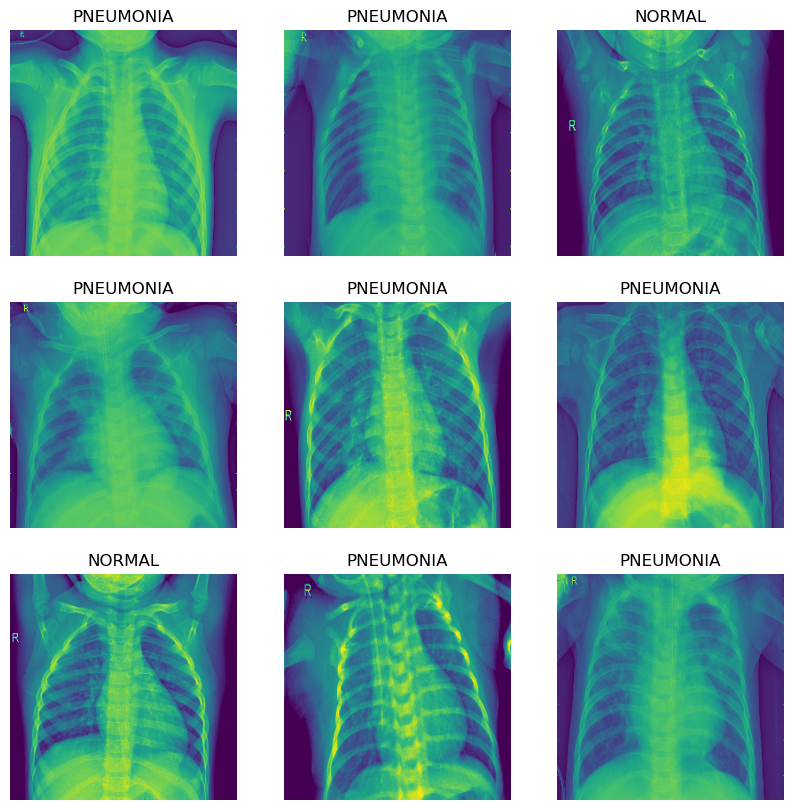

In [6]:

plt.figure(figsize = (10, 10))
for images, labels in combined_train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(np.squeeze(images[i].numpy().astype('uint8')))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis('off')


In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [8]:
model = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),  # Add dropout with a rate of 0.2 (20% of units will be dropped)
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),  # Add dropout with a rate of 0.2
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),  # Add dropout with a rate of 0.2
    layers.Flatten(),
    layers.Dense(128, activation='relu',kernel_regularizer= tf.keras.regularizers.L2(0.1)),
    layers.Dropout(0.2),  # Add dropout with a rate of 0.2
    layers.Dense(2, activation='softmax')
])

In [9]:
model.compile(
    optimizer = 'adam',
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
# Define the EarlyStopping callback
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Compile and fit the model with the EarlyStopping callback
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stopping_callback]
)

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                  

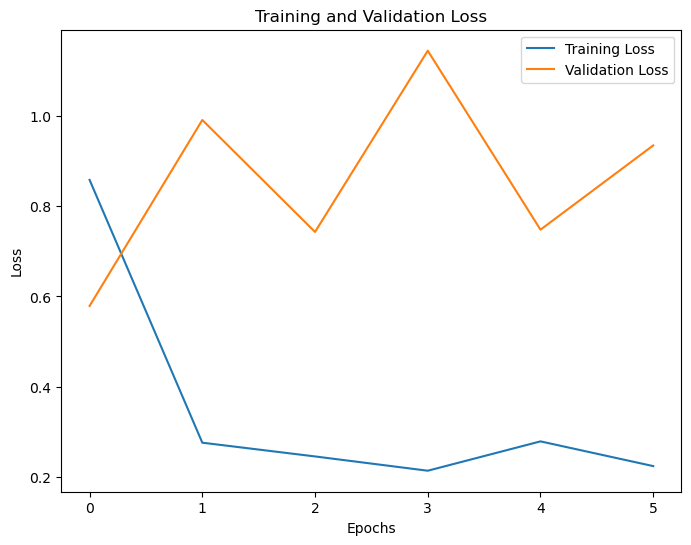

In [ ]:
# Retrieve the training and validation loss from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
vgg = VGG16(input_shape=IMG_SIZE + [3], weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 17s 0us/step


In [ ]:
folders = glob('C:/chest_xray/train/*')
x = Flatten()(vgg.output)

In [ ]:
prediction = Dense(len(folders), activation='softmax')(x)
# create a model object
modelt = Model(inputs=vgg.input, outputs=prediction)
# view the structure of the model
modelt.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
modelt.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,shear_range = 0.2,zoom_range = 0.2,horizontal_flip = True)

val_datagen = ImageDataGenerator(rescale = 1./255)




# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('C:/chest_xray/train',target_size = (224, 224),batch_size = 10,class_mode = 'categorical')




val_set =  val_datagen.flow_from_directory('C:/chest_xray/val',target_size = (224, 224),batch_size = 10,class_mode = 'categorical')
test_set =  val_datagen.flow_from_directory('C:/chest_xray/test',target_size = (224, 224),batch_size = 10,class_mode = 'categorical')


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
r = modelt.fit_generator(
  training_set,
  validation_data=val_set,
  epochs=1,
  steps_per_epoch=len(training_set),
  validation_steps=len(val_set)
)


522/522 [==============================] - 570s 1s/step - loss: 0.1692 - accuracy: 0.9390 - val_loss: 0.1760 - val_accuracy: 0.9375


In [ ]:
test_loss, test_accuracy = modelt.evaluate(test_set)

print("Test Loss: {:.4f}".format(test_loss))
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

63/63 [==============================] - 67s 1s/step - loss: 0.3624 - accuracy: 0.8926
Test Loss: 0.3624
Test Accuracy: 89.26%


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

image_path = "C:/chest_xray/train/NORMAL/NORMAL2-IM-1379-0001.jpeg"  # Replace with the path to your image file

# Load and preprocess the image
img = image.load_img(image_path, target_size=(256, 256), color_mode='grayscale')
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # Normalize the image pixel values

In [ ]:
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])

# Get the class label
class_names = ["Normal","Pneumonia"]  # Assuming train_ds contains the class names
predicted_label = class_names[predicted_class]
print(predictions)
print("Predicted class:", predicted_label)

In [ ]:
from sklearn.metrics import f1_score

true_labels = []
predicted_labels = []

for images, labels in test_set:
    predictions = modelt.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    
    true_labels.extend(labels)
    predicted_labels.extend(predicted_classes)

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels)

print("F1 Score:", f1)


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay

# Make predictions on the test dataset
y_pred = modelt.predict(test_set).argmax(axis=1)
y_true = np.concatenate([y for x, y in test_set], axis=0)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# # Calculate precision, recall, and F1 score
# report = classification_report(y_true, y_pred, target_names=train_ds.class_names, output_dict=True)
# precision = report['weighted avg']['precision']
# recall = report['weighted avg']['recall']
# f1_score = report['weighted avg']['f1-score']

cm_display= ConfusionMatrixDisplay(confusion_matrix= confusion_matrix, display_labels = [False,True])


plt.show()

# Print precision, recall, and F1 score
# print('Precision:', precision)
# print('Recall:', recall)
# print('F1 Score:', f1_score)


In [ ]:
import pickle

# Save model weights
model_weights = modelt.get_weights()
with open('model_weights.pkl', 'wb') as f:
    pickle.dump(model_weights, f)

# Save model architecture
model_architecture = modelt.to_json()
with open('model_architecture.pkl', 'wb') as f:
    pickle.dump(model_architecture, f)